# Feature Engineering: Walmart Sales Dataset

- [About the data](#data)
- [Baseline model](#baseline)
- Feature Engineering
    - [Date Features](#date)
    - [Inferred Features (from past)](#past)
    - [Encoding](#encoding)
- [Types of Feature Engineering](#types)
- [Conclusion](#conclusion)
- [Next Steps](#next)

In [198]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import date
from matplotlib import pyplot

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


import numpy as np

In [2]:
!which python; python -V;

'which' is not recognized as an internal or external command,
operable program or batch file.


In [3]:

# Automatically reloads modules on code changes
# Note: Does NOT automatically reload on cofiguration file changes
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:

from preprocessing import Preprocessor
df = Preprocessor.load_and_process('../data/processed/CA_1_sales_data.csv')
df.head()

ModuleNotFoundError: No module named 'preprocessing'

In [4]:
sys.path

['c:\\Users\\xiche\\Desktop\\MSDS\\DSCI591\\Walmart-Strategic-Sales-Forecasting\\notebooks',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\python310.zip',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\DLLs',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\lib',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast',
 '',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\lib\\site-packages',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\lib\\site-packages\\win32',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\lib\\site-packages\\win32\\lib',
 'c:\\Users\\xiche\\anaconda3\\envs\\walmart-forecast\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\xiche\\Desktop\\MSDS\\DSCI591\\Walmart-Strategic-Sales-Forecasting',
 'c:\\Users\\xiche\\Desktop\\MSDS\\DSCI591\\Walmart-Strategic-Sales-Forecasting']

## About the data

This dataset contains the daily sales of a Walmart store between years 2011 and 2016.

Let's read it in and take a look!

In [23]:
df = pd.read_csv('../data/processed/CA_1_sales_data.csv', index_col=0, parse_dates=True)
df.head()

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,gas_price,snap_ca,ca_walmart,ca_hobbies,ca_household,ca_foods,store_sales,median_price,min_price,max_price
2011-01-29,11101,1,1,2011,None,None,None,None,221.187,9.1,3.163,0,39.50,20.14,36.5,63.00,4337.0,3.18,0.2,20.0
2011-01-30,11101,2,1,2011,None,None,None,None,221.187,9.1,3.163,0,42.50,30.02,29.0,67.90,4155.0,3.18,0.2,20.0
2011-01-31,11101,3,1,2011,None,None,None,None,221.187,9.1,3.155,0,36.50,22.42,48.0,60.90,2816.0,3.18,0.2,20.0
2011-02-01,11101,4,2,2011,None,None,None,None,221.898,9.0,3.155,1,42.40,19.08,38.5,62.70,3051.0,3.18,0.2,20.0
2011-02-02,11101,5,2,2011,None,None,None,None,221.898,9.0,3.155,1,38.69,21.96,35.2,57.42,2630.0,3.18,0.2,20.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1951 entries, 2011-01-29 to 2016-06-01
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wm_yr_wk           1951 non-null   int64  
 1   wday               1951 non-null   int64  
 2   month              1951 non-null   int64  
 3   year               1951 non-null   int64  
 4   event_name_1       1951 non-null   object 
 5   event_type_1       1951 non-null   object 
 6   event_name_2       1951 non-null   object 
 7   event_type_2       1951 non-null   object 
 8   cpi                1951 non-null   float64
 9   unemployment_rate  1951 non-null   float64
 10  gas_price          1951 non-null   float64
 11  snap_ca            1951 non-null   int64  
 12  ca_walmart         1951 non-null   float64
 13  ca_hobbies         1951 non-null   float64
 14  ca_household       1951 non-null   float64
 15  ca_foods           1951 non-null   float64
 16  store_

In [25]:
df.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-05-23', '2016-05-24', '2016-05-25', '2016-05-26',
               '2016-05-27', '2016-05-28', '2016-05-29', '2016-05-30',
               '2016-05-31', '2016-06-01'],
              dtype='datetime64[ns]', length=1951, freq=None)

<AxesSubplot:>

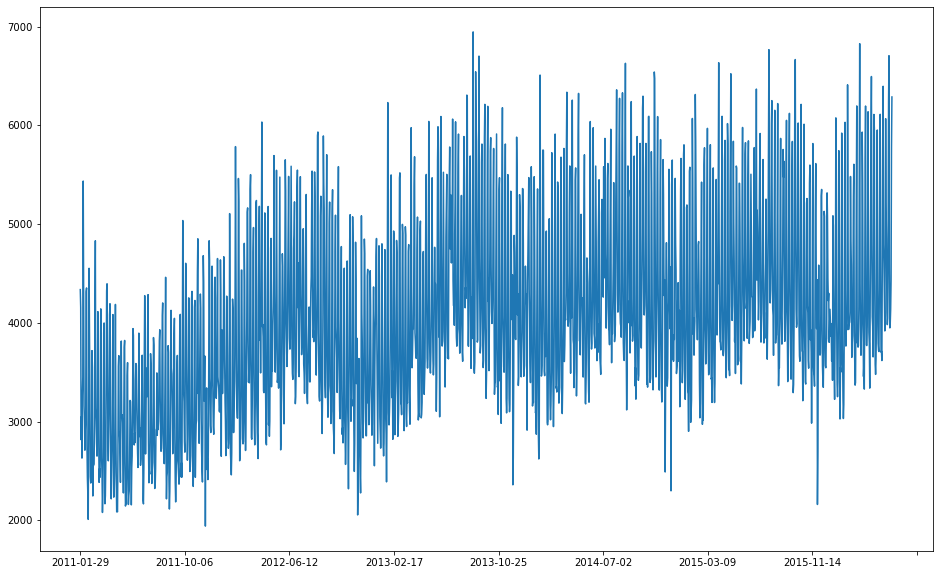

In [19]:
df['store_sales'].plot(figsize=(16,10))

In [27]:
df = df.dropna()

### Plot the sale by month - how does the sale change between the years?

<AxesSubplot:>

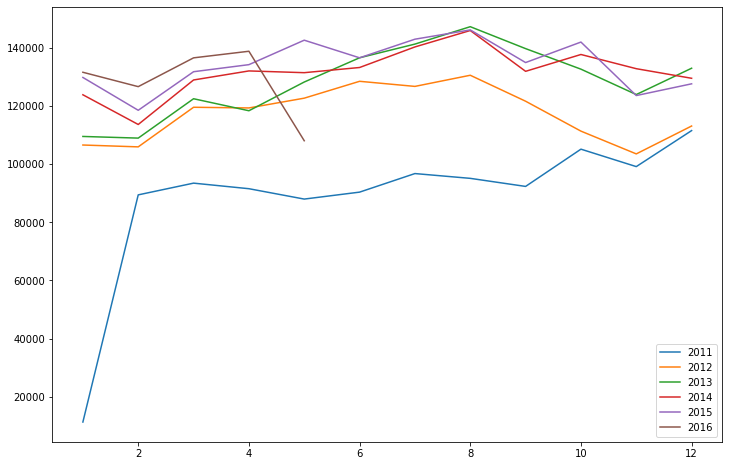

In [31]:
df['store_sales'].groupby([df.index.month, df.index.year]).sum().unstack().plot(figsize=(12, 8))

## Baseline model

The datetime format as it is currently presented is great for an index, however it is not usable for our sklearn pipeline. We already have data that represents the year, month, weekday, and week number (wm_yr_wk). We will add data to represent the day as well.

### Pandas Pipelines: 

In pandas we can use the `.pipe()` method to modularise our code and create clean code! 

We do this by creating functions that section our code. Each function takes in a dataframe as an argument; we then use this function with the pipe method to run.

In [32]:
def get_day_value(df):
    """ Preprocessing function
    Creates day column.
    """
    df = df.assign(**{'day': df.index.day})
    
    return df

df_processed = df.pipe(get_day_value)
df_processed.tail()

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,snap_ca,ca_walmart,ca_hobbies,ca_household,ca_foods,store_sales,median_price,min_price,max_price,day
2016-05-18,11616,5,5,2016,None,None,None,None,239.557,4.8,...,0,23.04,34.20,50.05,52.64,3995.0,3.48,0.23,29.97,18
2016-05-19,11616,6,5,2016,None,None,None,None,239.557,4.8,...,0,23.40,26.79,50.70,49.84,4136.0,3.48,0.23,29.97,19
2016-05-20,11616,7,5,2016,None,None,None,None,239.557,4.8,...,0,23.76,40.47,37.70,51.52,4433.0,3.48,0.23,29.97,20
2016-05-21,11617,1,5,2016,None,None,None,None,239.557,4.8,...,0,30.24,44.46,39.00,48.72,5764.0,3.48,0.23,29.97,21
2016-05-22,11617,2,5,2016,None,None,None,None,239.557,4.8,...,0,31.68,29.07,42.90,53.76,6289.0,3.48,0.23,29.97,22


In [41]:
cat_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

***Scikit Learn Steps***

1. Split data into X and y (features & target)
2. Encode the features in X where necessary (eg. create dummies)
3. Create train test split (without shuffling so the holdout is always the tail end of the data)
4. Build the model using a pipeline and specified model algorithm
5. Evaluate the model using Scikit Learn metrics (in our case r2)

In [222]:
def get_Xy(df, target_feature='store_sales', onehotencoding=cat_cols):
    
    # create dummy features
    
    if onehotencoding:
        df = (
            df
            .join([pd.get_dummies(df[col], prefix=col) for col in onehotencoding])
            .drop(onehotencoding, axis=1)
            .rename(str.lower, axis=1)
        )
    
    # split the independent features and the target into X and y
    
    X = df.drop([target_feature], axis=1)
    y = df.loc[:, target_feature]
    
    return X, y

def train_model(X, y, model):     
    """ Trains model
    
    X: pandas DataFrame of the features
    y: pandas Series of the target variable
    model: sklearn model
    """
    
    # create train-test set split. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
        
    # train the model. 
    pipeline = Pipeline(steps = [
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # evaluate the model. 
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)
    score_train = r2_score(y_train, y_train_pred)
    score = r2_score(y_test, y_pred)
    print(f'Building model: {model}'.split('(')[0])
    print(f'Train score: {score_train.round(2)}')
    print(f'Test score: {score.round(2)}\n')
    plot_pred_vs_test(y_pred, y_test)
    return pipeline

def plot_pred_vs_test(y_pred, y_test):
    y = pd.DataFrame(y_test)
    y['pred'] = y_pred
    y.plot(figsize=(15, 9))

All our steps are defined! Time to initlialise our models, process our data and train the models. 

In [34]:
forest_model = RandomForestRegressor(max_depth=6, random_state=1)
linear_model = LinearRegression()

We are only going to use **pandas pipelines to clean** the data since we are only changing one dataframe in these steps. 

When we build we actually need to consider the split of `X` (the independent features) and `y` (the target feature). Therefore when we're building the models we will just use the standard syntax when using functions.

In [46]:
# split X and y
X, y = df_processed.pipe(get_Xy)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.65
Test score: 0.41

Building model: RandomForestRegressor
Train score: 0.9
Test score: 0.79



We use the r2 scoring metric, which scores a model between 0.0 - 1.0. 1.0 is the best score a model can achieve, so Linear Regression in this case is doing worse than the Random Forest regressor. But both models could use some improvements. 

Let's see if we can construct further features that will allow our models to learn.

### Engineered features: date features
Feature engineering is the practice of adding features to your data based on what you think might provide additonal information. Let's think about this problem: our dataset concerns bike rentals. One might imagine the number of bikes rented may be correlated to the days people work, i.e. people will rent a bike to commute to work. Thinking about the dates, there are a couple of features of interest that we might want to add to our dataset:

* Is a day a holiday (pre-defined set of dates)? 
* What is the day of the week (Monday, Tuesday, etc.)?
* What season is it?

Create a new variable `HOLIDAYS` using the `holidays` package.

In [74]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
HOLIDAYS = cal.holidays('2011-01-19', '2016-06-01')
HOLIDAYS

Let's create some function that will create new features as per the questions above:

In [85]:
def is_holiday(df):
    """Return a new column is_holiday
    Input: dataframe (df) with date column (default datetime)
    True when the date is a holiday 
    False when the date is not a holiday"""
    
    return df.assign(is_holiday = pd.to_datetime(df.index.date).isin(HOLIDAYS))


def get_season(df):
    """Return the season based off:
    Dec, Jan, Feb = winter
    Mar, Apr, May = spring
    Jun, Jul, Aug = summer
    Sep, Oct, Nov = autumn"""
    
    season_mapping = {4: 'winter',
                      1: 'spring',
                      2: 'summer',
                      3: 'autumn'}
    
    # map the dates quarter to what season it is
    offset_months = df.index - pd.DateOffset(months=1)
    seasons = offset_months.quarter.map(season_mapping)
    
    return df.assign(season = seasons)

In [86]:
df_processed = (
    df_processed
        .pipe(is_holiday)
        .pipe(get_season)
)

In [89]:
df_processed.is_holiday.sum()

55

In [91]:
df_processed.head()

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,ca_hobbies,ca_household,ca_foods,store_sales,median_price,min_price,max_price,day,is_holiday,season
2011-01-29,11101,1,1,2011,None,None,None,None,221.187,9.1,...,20.14,36.5,63.00,4337.0,3.18,0.2,20.0,29,False,winter
2011-01-30,11101,2,1,2011,None,None,None,None,221.187,9.1,...,30.02,29.0,67.90,4155.0,3.18,0.2,20.0,30,False,winter
2011-01-31,11101,3,1,2011,None,None,None,None,221.187,9.1,...,22.42,48.0,60.90,2816.0,3.18,0.2,20.0,31,False,winter
2011-02-01,11101,4,2,2011,None,None,None,None,221.898,9.0,...,19.08,38.5,62.70,3051.0,3.18,0.2,20.0,1,False,spring
2011-02-02,11101,5,2,2011,None,None,None,None,221.898,9.0,...,21.96,35.2,57.42,2630.0,3.18,0.2,20.0,2,False,spring


### Feature generation

Create a boolean column called `is_weekday` where True is a weekday (Mon-Fri) and False a weekend day (Sat-Sun)

`wday` starts from Saturday.

In [92]:
df_processed.wday.unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [93]:
df_processed = df_processed.assign(is_weekday=lambda df: df.wday > 2)
df_processed

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,ca_household,ca_foods,store_sales,median_price,min_price,max_price,day,is_holiday,season,is_weekday
2011-01-29,11101,1,1,2011,None,None,None,None,221.187,9.1,...,36.50,63.00,4337.0,3.18,0.20,20.00,29,False,winter,False
2011-01-30,11101,2,1,2011,None,None,None,None,221.187,9.1,...,29.00,67.90,4155.0,3.18,0.20,20.00,30,False,winter,False
2011-01-31,11101,3,1,2011,None,None,None,None,221.187,9.1,...,48.00,60.90,2816.0,3.18,0.20,20.00,31,False,winter,True
2011-02-01,11101,4,2,2011,None,None,None,None,221.898,9.0,...,38.50,62.70,3051.0,3.18,0.20,20.00,1,False,spring,True
2011-02-02,11101,5,2,2011,None,None,None,None,221.898,9.0,...,35.20,57.42,2630.0,3.18,0.20,20.00,2,False,spring,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,5,5,2016,None,None,None,None,239.557,4.8,...,50.05,52.64,3995.0,3.48,0.23,29.97,18,False,summer,True
2016-05-19,11616,6,5,2016,None,None,None,None,239.557,4.8,...,50.70,49.84,4136.0,3.48,0.23,29.97,19,False,summer,True
2016-05-20,11616,7,5,2016,None,None,None,None,239.557,4.8,...,37.70,51.52,4433.0,3.48,0.23,29.97,20,False,summer,True
2016-05-21,11617,1,5,2016,None,None,None,None,239.557,4.8,...,39.00,48.72,5764.0,3.48,0.23,29.97,21,False,summer,False


2. Create a boolean column called `is_workday` where True is a WORK day (Mon-Fri but NOT a bank holiday) and False a weekend day or Bank Holiday (Sat-Sun and other bank holiday days)

In [94]:
df_processed = df_processed.assign(is_workday=lambda df: (df['is_weekday']==True) & (df['is_holiday']==False))
df_processed

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,ca_foods,store_sales,median_price,min_price,max_price,day,is_holiday,season,is_weekday,is_workday
2011-01-29,11101,1,1,2011,None,None,None,None,221.187,9.1,...,63.00,4337.0,3.18,0.20,20.00,29,False,winter,False,False
2011-01-30,11101,2,1,2011,None,None,None,None,221.187,9.1,...,67.90,4155.0,3.18,0.20,20.00,30,False,winter,False,False
2011-01-31,11101,3,1,2011,None,None,None,None,221.187,9.1,...,60.90,2816.0,3.18,0.20,20.00,31,False,winter,True,True
2011-02-01,11101,4,2,2011,None,None,None,None,221.898,9.0,...,62.70,3051.0,3.18,0.20,20.00,1,False,spring,True,True
2011-02-02,11101,5,2,2011,None,None,None,None,221.898,9.0,...,57.42,2630.0,3.18,0.20,20.00,2,False,spring,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,5,5,2016,None,None,None,None,239.557,4.8,...,52.64,3995.0,3.48,0.23,29.97,18,False,summer,True,True
2016-05-19,11616,6,5,2016,None,None,None,None,239.557,4.8,...,49.84,4136.0,3.48,0.23,29.97,19,False,summer,True,True
2016-05-20,11616,7,5,2016,None,None,None,None,239.557,4.8,...,51.52,4433.0,3.48,0.23,29.97,20,False,summer,True,True
2016-05-21,11617,1,5,2016,None,None,None,None,239.557,4.8,...,48.72,5764.0,3.48,0.23,29.97,21,False,summer,False,False


Now we retrain the model on our new data:

In [107]:
# split X and y
cat_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'season']
X, y = get_Xy(df_processed, onehotencoding=cat_cols)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.8
Test score: 0.61

Building model: RandomForestRegressor
Train score: 0.9
Test score: 0.79



So far we haven't got much improvement in the Random Forest, but there is improvement in the LR model.

### Engineered features: past behaviour
Another assumption we can make - and try out - is that behaviour in the past at similar time points might be predictive of behaviour of future behaviour

In [108]:
df_processed.head()

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,ca_foods,store_sales,median_price,min_price,max_price,day,is_holiday,season,is_weekday,is_workday
2011-01-29,11101,1,1,2011,None,None,None,None,221.187,9.1,...,63.00,4337.0,3.18,0.2,20.0,29,False,winter,False,False
2011-01-30,11101,2,1,2011,None,None,None,None,221.187,9.1,...,67.90,4155.0,3.18,0.2,20.0,30,False,winter,False,False
2011-01-31,11101,3,1,2011,None,None,None,None,221.187,9.1,...,60.90,2816.0,3.18,0.2,20.0,31,False,winter,True,True
2011-02-01,11101,4,2,2011,None,None,None,None,221.898,9.0,...,62.70,3051.0,3.18,0.2,20.0,1,False,spring,True,True
2011-02-02,11101,5,2,2011,None,None,None,None,221.898,9.0,...,57.42,2630.0,3.18,0.2,20.0,2,False,spring,True,True


We enrich our previously created dataframe that has been processed and had date-related features added with our new features and see how this influences model performance.

In [144]:
def remove_first(df, col_nam, timedelta):
    """ Return a cleaned version of column col_nam
    Input: dataframe (df) with a column (col_nam) and time window (timedelta)
    Keep the original column value if sufficient period of time has elapsed (timedelta)
    Otherwise return NaN """
    return (df
            .assign(**{col_nam: 
                       lambda df: np.where(df.index >= (df.index.min() + pd.Timedelta(timedelta)),
                                           df[col_nam], 
                                           np.nan)
                      })
           )


def get_mean_of_previous(df, col_nam, timedelta, 
                         prev_col='store_sales', agg='mean'):
    """
    Return a new column col_name with the mean count of a previous time period
    
    Input: dataframe (df) with a column (col_nam), 
    window for rolling averages (timedelta), period of time to groupby (grouper),
    column to aggregate on and aggregation function (default 'mean').
    """
    
    return (
        df
        .assign(**{col_nam: (lambda df: df
                                   .sort_index()
                                    #allow for not grouping by time
                                   .assign(NoGroup=1)
                                    #rolling average using only past data
                                   .rolling(timedelta, closed='left')
                                    #aggregate on the column
                                   [prev_col].agg(agg)
                                  )})
        .pipe(remove_first, col_nam, timedelta)
    )

In [145]:
df_inferred = (
    df_processed
    .pipe(get_mean_of_previous, col_nam='last_7_days', timedelta='7D')
    .pipe(get_mean_of_previous, col_nam='last_4_weeks', timedelta='28D')
)

In [146]:
df_inferred.tail()

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,median_price,min_price,max_price,day,is_holiday,season,is_weekday,is_workday,last_7_days,last_4_weeks
2016-05-18,11616,5,5,2016,None,None,None,None,239.557,4.8,...,3.48,0.23,29.97,18,False,summer,True,True,4921.571429,4747.250000
2016-05-19,11616,6,5,2016,None,None,None,None,239.557,4.8,...,3.48,0.23,29.97,19,False,summer,True,True,4923.428571,4757.000000
2016-05-20,11616,7,5,2016,None,None,None,None,239.557,4.8,...,3.48,0.23,29.97,20,False,summer,True,True,4935.857143,4772.250000
2016-05-21,11617,1,5,2016,None,None,None,None,239.557,4.8,...,3.48,0.23,29.97,21,False,summer,False,False,4861.857143,4773.892857
2016-05-22,11617,2,5,2016,None,None,None,None,239.557,4.8,...,3.48,0.23,29.97,22,False,summer,False,False,4793.142857,4780.571429


### Rebuild the model
Use the functions: `get_Xy` and `train_model` to get model performance metrics on the data with past behaviour metrics. 

In [148]:
# split X and y
X, y = get_Xy(df_inferred, onehotencoding=cat_cols)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.83
Test score: 0.77

Building model: RandomForestRegressor
Train score: 0.91
Test score: 0.82



Both model seem to have improved.

We can add more historical behavior features such the daily sales (not aggregated) from a week, a month, or a year ago.

In [176]:
def get_last_period(df, col_name, periods):
    return df.assign(**{col_name: (lambda df: df.store_sales.shift(periods))})

In [189]:
df_inferred = (
    df_inferred
    .pipe(get_last_period, col_name='yesterday', periods=1)
    .pipe(get_last_period, col_name='last_week', periods=7)
    .pipe(get_last_period, col_name='last_month', periods=30)
    .pipe(get_last_period, col_name='last_year', periods=365)
)

In [190]:
df_inferred.tail()

,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,cpi,unemployment_rate,...,is_holiday,season,is_weekday,is_workday,last_7_days,last_4_weeks,last_week,last_month,last_year,yesterday
2016-05-18,11616,5,5,2016,None,None,None,None,239.557,4.8,...,False,summer,True,True,4921.571429,4747.250000,3982.0,4345.0,3576.0,3949.0
2016-05-19,11616,6,5,2016,None,None,None,None,239.557,4.8,...,False,summer,True,True,4923.428571,4757.000000,4049.0,3793.0,3580.0,3995.0
2016-05-20,11616,7,5,2016,None,None,None,None,239.557,4.8,...,False,summer,True,True,4935.857143,4772.250000,4951.0,3722.0,3635.0,4136.0
2016-05-21,11617,1,5,2016,None,None,None,None,239.557,4.8,...,False,summer,False,False,4861.857143,4773.892857,6245.0,3709.0,4578.0,4433.0
2016-05-22,11617,2,5,2016,None,None,None,None,239.557,4.8,...,False,summer,False,False,4793.142857,4780.571429,6707.0,4387.0,5415.0,5764.0


In [191]:
X, y = get_Xy(df_inferred, onehotencoding=cat_cols)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Building model: LinearRegression
Train score: 0.88
Test score: 0.85

Building model: RandomForestRegressor
Train score: 0.9
Test score: 0.82



LR performance increased, but RF performance decreased.

### Feature Importance 

From here it would be good to start looking at feature selection and see if we can actually reduce amount of features we use. 

Let's take a quick look at feature importance...

In [192]:
rf['model']

RandomForestRegressor(max_depth=6, random_state=1)

In [ ]:
from src.preprocessing import Preprocessor
Preprocessor.load_and_process()

In [193]:
rf['model'].feature_importances_

array([6.97611565e-03, 3.38816495e-02, 2.75027534e-03, 1.71114699e-04,
       3.94514948e-03, 2.62791554e-03, 4.24326929e-03, 1.62431398e-03,
       5.25706146e-03, 2.48056139e-03, 2.04624555e-03, 6.34957786e-03,
       1.03117550e-03, 1.41689345e-04, 4.08162669e-04, 5.11826527e-02,
       1.21296225e-04, 2.06877998e-02, 4.82575731e-03, 2.02492861e-02,
       1.63058342e-02, 7.28831857e-01, 1.17068036e-02, 7.19922286e-03,
       5.45986361e-02, 0.00000000e+00, 0.00000000e+00, 1.66276028e-06,
       0.00000000e+00, 2.88436316e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.08537567e-06, 0.00000000e+00, 1.42651444e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.83417833e-05, 0.00000000e+00, 0.00000000e+00, 1.27155956e-03,
       8.82494663e-04, 0.00000000e+00, 8.04001285e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.23771253e-05, 1.53555697e-03, 0.00000000e+00, 0.00000000e+00,
      

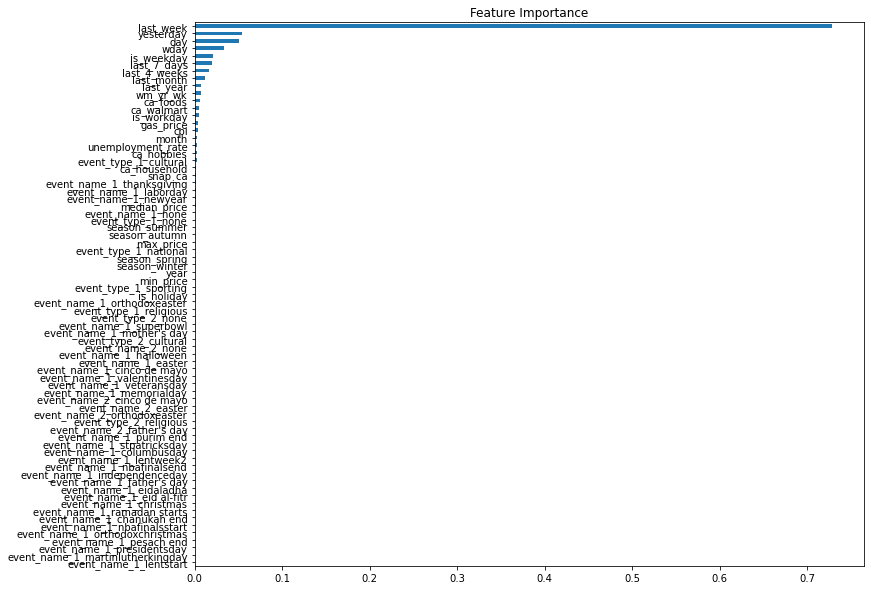

In [194]:
(
    pd.Series(rf.named_steps['model'].feature_importances_, 
              X.columns)
    .sort_values()

    .plot(kind='barh', figsize=(12,10), title='Feature Importance')
);

From here we can see that the engineered past behavior features are quite important. Other important features also include the dat time information, Google trends data, gas prices, CPI, unemployment rate, etc. The event names themselves are basically useless; maybe we can consolidate the information there and see if the model performance improves. 

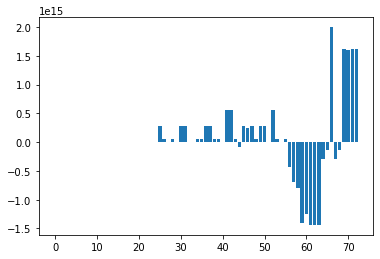

In [200]:
importance = linear_model.coef_
# plot feature importance for linear regression model
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Drop Event Name Columns

In [201]:
df_dropped = df.drop(columns=['event_name_1', 'event_name_2'])

In [202]:
df_dropped = (
    df_dropped
        .pipe(get_day_value)
        .pipe(is_holiday)
        .pipe(get_season)
        .assign(is_weekday=lambda df: df.wday > 2)
        .assign(is_workday=lambda df: (df['is_weekday']==True) & (df['is_holiday']==False))
        .pipe(get_mean_of_previous, col_nam='last_7_days', timedelta='7D')
        .pipe(get_mean_of_previous, col_nam='last_4_weeks', timedelta='28D')
        .pipe(get_last_period, col_name='yesterday', periods=1)
        .pipe(get_last_period, col_name='last_week', periods=7)
        .pipe(get_last_period, col_name='last_month', periods=30)
        .pipe(get_last_period, col_name='last_year', periods=365)
)

In [203]:
df_dropped

,wm_yr_wk,wday,month,year,event_type_1,event_type_2,cpi,unemployment_rate,gas_price,snap_ca,...,is_holiday,season,is_weekday,is_workday,last_7_days,last_4_weeks,yesterday,last_week,last_month,last_year
2011-01-29,11101,1,1,2011,None,None,221.187,9.1,3.163,0,...,False,winter,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-30,11101,2,1,2011,None,None,221.187,9.1,3.163,0,...,False,winter,False,False,NaN,NaN,4337.0,NaN,NaN,NaN
2011-01-31,11101,3,1,2011,None,None,221.187,9.1,3.155,0,...,False,winter,True,True,NaN,NaN,4155.0,NaN,NaN,NaN
2011-02-01,11101,4,2,2011,None,None,221.898,9.0,3.155,1,...,False,spring,True,True,NaN,NaN,2816.0,NaN,NaN,NaN
2011-02-02,11101,5,2,2011,None,None,221.898,9.0,3.155,1,...,False,spring,True,True,NaN,NaN,3051.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,11616,5,5,2016,None,None,239.557,4.8,2.345,0,...,False,summer,True,True,4921.571429,4747.250000,3949.0,3982.0,4345.0,3576.0
2016-05-19,11616,6,5,2016,None,None,239.557,4.8,2.345,0,...,False,summer,True,True,4923.428571,4757.000000,3995.0,4049.0,3793.0,3580.0
2016-05-20,11616,7,5,2016,None,None,239.557,4.8,2.345,0,...,False,summer,True,True,4935.857143,4772.250000,4136.0,4951.0,3722.0,3635.0
2016-05-21,11617,1,5,2016,None,None,239.557,4.8,2.345,0,...,False,summer,False,False,4861.857143,4773.892857,4433.0,6245.0,3709.0,4578.0


Building model: LinearRegression
Train score: 0.86
Test score: 0.83

Building model: RandomForestRegressor
Train score: 0.9
Test score: 0.82



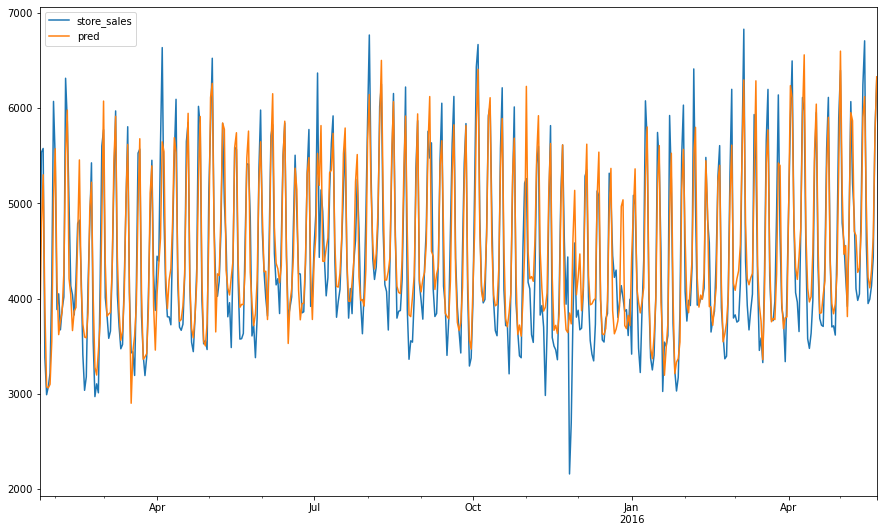

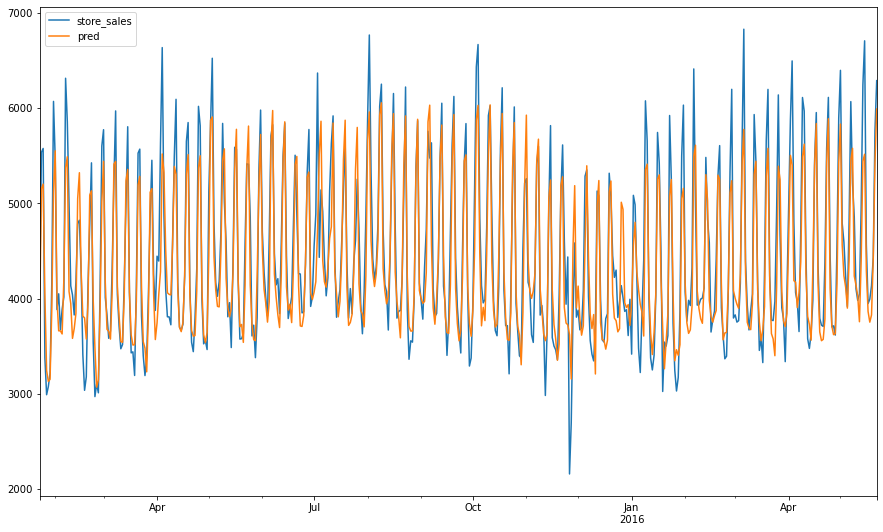

In [223]:
cat_cols = ['event_type_1', 'event_type_2', 'season']
X, y = get_Xy(df_dropped, onehotencoding=cat_cols)

# train models
lm = train_model(X, y, linear_model)
rf = train_model(X, y, forest_model)

Performance slightly decreased.